### Testing the Hybrid LinUCB Li's algorithm - Msc Project

Markos Flavio B. G. O.

__Context: contextual bandits.__

The objective of this notebook is to test the general behavior of the Hybrid LinUCB algorithm of policy adaptation and reward maximization proposed by [1].

__Specific objectives__
    1. Building the general intuition about how the action values can impact the context-reward functions.
    2. Testing the Hybrid LinUCB approach
      2.1 Building the client's algorithm
      2.2 Testing the algorithm in a single context
      2.3 Testing the algorithm in two very different contexts (to do)

In [141]:
# adding the .py path to be visible to this program
import sys
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import random
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
sys.path.append(r'C:\Dropbox\_Studies\_Python Scripts\MSC\Spyder')
import linucb_v2 as lucb
from sklearn.linear_model import Ridge
from IPython.display import Image
import seaborn as sns # for heatmap
reload(lucb) # so that changes in .py can be observed by this notebook without kernel disconnection.

<module 'linucb_v2' from 'C:\\Dropbox\\_Studies\\_Python Scripts\\MSC\\Spyder\\linucb_v2.py'>

### 1. Building the general intuition about how the action values can impact the context-reward functions

The contextual bandits approach states that for each context there's an optimal arm from a set of arms.
The idea is to learn the best arm in each of the contexts in a way that the cumulative reward is maximized.

Below, we'll analyze some aspects of this problem where contexts are defined in the metric space. The analysis will consider a single arm only.

When the set of contexts is small and there's no relationship between them, an effective way of handling the problem is to run a copy of UCB algorithm for each context, as proposed by the author of [3] in section 8.1. That's actually the case of the problem approached in [4]. In this case, the contexts are not completely independent being represented by a binary encoding approach: two binary features encoding four *context values*: (0,0), (0,1), (1,0) and (1,1) (see Table 1.1 in [4]). This encoding is often used when the features are ordinal categories (an order can be stablished between categories even though the differences between them cannot be measured).

The benefit of using the context values using separate UCB models for each context is to use an information that's instantly available at each iteration to *specialize* the action selection. The penalty you pay (there's no free lunch) is that you multiply the regret of the plain-UCB algorithm by the number of contexts (|X|) (see Theorem 8.1 in [3]): it makes sense; this means that it's |X| easier (probabilistically, assuming a fixed confidence level *c*) to find the best action overall as to find the best one in each of the |X| contexts.

Now, even though the categories share some ordinal relationship, the points represent individual and distinct points in the (x,y) plane. For each x,y pair covered in the fout context values, the idea is to learn the expected context-reward value, that can be described in the z-axis. Now, [4] have run the LinUCB approach for this case. In such framework, an hyper-plane will be learned comprising three distinct features (check Table 1.2 in [4]).

Let's check this approach in a simpler version of this same framework where we have only one feature comprising two context values (0 and 1).

Text(0, 0.5, 'Recompensa')

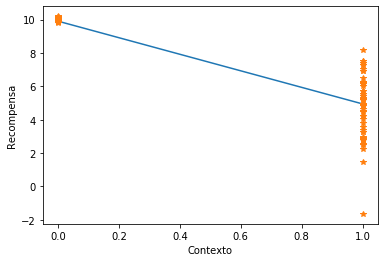

In [3]:
v = [1,0]
x_values = []
y_values = []

# creating samples of reward values for two distributions defined in each of the contexts.
for i in range(100):
    x_value = random.choice(v) 
    if x_value == 0:
        mu, sigma = 10, 0.1 # mean and standard deviation
    else: # == 1
        mu, sigma = 5, 2 # mean and standard deviation
    y_value = np.random.normal(mu, sigma, 1)
    x_values.append(x_value)
    y_values.append(y_value)
    
# learning the ridge regression    
clf = Ridge(alpha=1.0)
X = np.array(x_values).reshape(-1, 1)
y = np.array(y_values).reshape(-1, 1)
clf.fit(X, y)
ridge_prediction = clf.predict(np.array(v).reshape(-1, 1))

# plotting
plt.plot(np.array(v).reshape(-1, 1), ridge_prediction, label='Linear fitting')
plt.plot(x_values, y_values, '*')
plt.xlabel('Contexto')
plt.ylabel('Recompensa')

Intuitivelly, fitting a linear model (or any other regression function whose codomain is R) to this case isn't feel right, even though it can correctly point out to the true expected values of reward for each context. Even though it does the job, it defines context-reward values for all other context values in between which will never occur in the problem.

Also, this approach does not model well the reward values for each context value assuming the binary encoding when the number of raw features increases.

  - In the above example, one raw feature specifies two distinct context values; however this values are included in the same variable and only one parameter exists for the feature. Each context value will have a idependent context-reward relationship which will be learned. The ridge regression line defined in the 2d plot has two parameters (including one for the threshold), which can be used to correclty fit the expected reward over the two distinct points in the 2d-space; that's possible because the model has a number of degrees of freedom equal to the number of context values.
  
  - In the example covered in [4], there's two raw features (d=2) and four possible context values due to the binary encoding. In this case, a hyper-plane is defined in the 3d-space with three parameters (a, b, c; z = ax + by + c; 2+1 including the threshold parameter). This plane cannot fit the expeceted reward values for each of the four points (excluding "singularity cases") because simply it does not have the necessary degrees of freedom. It's restricted to the linear structure of the model and the best linear aproximation (as well as the parameters' compromise according to regularization of ridge) will be searched on. Naturally, there's such limitation when multiples plain-UCB algorithms are considered.
  
  - In a case with 8 context values (from three original raw features) it's even worse. A hyper-plane in the 4d space (d+1) is defined and only four parameters try to fit 8 distinct context-reward values.
  
The above analysis is valid for the binary encoding. One approach that can avoid this underfitting problem (that occurs when the model has to much bias), is to use the one-hot-encoding approach that defines an individual parameter for each of the catogorical features. In this case, the degrees of freedom are always the same as the number of the necessary context values. Naturally, a problem of overfitting may occur and theoretically, more data is necessary so that the plane fits correctly to the mean rewards.

Interessantly, note that the way we encode the conext information available changes the capacity of adjustment, the expected error and regret of the linear model. Eventually, as more parameters we've include in the context vector, more data proportionally is needed: that's captured by the variable 'd' inside the regret formulation of LinUCB (see below).

Now, coming back to LinUCB, its regret is ~O(sqrt(K*d*T)); where d is the size of the context vector (in the graph above, d=1). This bound has a similar complexity as the one that generates one UCB algorithm for each context when one-hot-encding is considered (d=|x|). However, according to [1] it's only valid when the expected reward-context function is given by a linear relationship. In the example plotted above, even though the linear fit can point to the average expeceted values, probably the bound is not valid because there isn't a intrinsic linear relationship. For example, linear models assumes:

   - Normality distributed error: the data points follow a normal distribution around the mean value at each point of the context: that's actually true in the plotted data above, because for each context we've defined a normal distribution that generates the data.
   - Homogeneous variance: the reward distributions have the same variance for each of the context: that's acutally not true in our case above because different reward distributions were defined for each context. More than that, this condition probably isn't true in general, considering **independent** contexts, an assumption that states that the variances of the independent context-reward relationships are the same is too strong. In general, we assume independent unknown relationships. Note that this condition covers only the variance because the mean is assumed to be different across contexts even though a linear relatinoship should exist.

In terms of regret, is not clear which approach is the best (multiple plain-UCBs vs LinUCB). This probably depends on the number of samples, the encoding type, the underlying context-reward relatinoship, etc. Even though it's always possible to experimentally check which approach is the best one, intuitivelly, the LinUCB case should be used when contexts are sampled from a big set of values, when building a model that generalizes reward across context values is essential.

The discussion above is not too relevent for our Msc hyper-heuristic problem where we have a context which is defined in the metric space; the stagnation (a linear function of the number makespan evaluations wihout iprovement). This context can assume any integer value between two practical limits: 0, 100, 10000, 2000, 1M. In this case, it's **essential** besides interesting to create a model that generalizes rewards for any value of context (as LinUCB does) because it's not possible to build a bandit for each independent context (it could be that no context values are repeated during the search!). It makes sense to define an approximation function because the contexts are not independent anymore. There's some structure in that makes nearby context to have similar expected reward and that can be exploited: this makes the reward values change smoothly across nearby contexts. Naturally, this makes sense in general. It doesn't make sense to have infinitesimally close context values that do not share any kind of relationship between the expected rewards (at least, a nonlinear relationship is expected). If no relationship exists, no function would approximate well the context-reward relationship and the only hope is to apply infinitely many bandits (if the context values are allowed to be continuous) to the problem, which is clearly unfeasible. One thing is true: if there's no relatnioship, this can be checked experimentally by looking at the performance of the mapproximaiton function at unseen data.

In a case in which the feature (here, the context) may assume multiple or even infinite values, we say that it's defined over a ratio-scale. All contexts now share a structure in terms of rewards given by the approximation function, whose have infinitely less parameters (or degrees of freedom) than reward values. However, that's the only option in this case: to rely on an approximation. Therefore, by using the stagnation as context variable, even though it can assume infinitely many numbers, it's still related to the context-reward relationship through only two parameters (a,b: ax+b); d=2 in the regret analysis of the LinUCB algorithm, which is also the size of the context vector.

From the discussion above we may say the following: *Because contexts are defined in the metric space, the expected-rewards of a single arm varies smoothly across contexts.*

Now, in a case in which the arm values are independent we may have the following sitation. Note again that, what "guarantees" that each arm moves smoothly across contexts is that they are not independent ans instead varies continuously on the metric space.

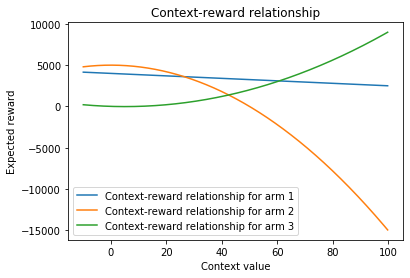

In [4]:
x = np.arange(-10, 100, 0.1)
c1 = -15*x + 4000
c2 = -2*x**2 + 5000
c3 = x**2 - 10*x + 5
plt.title('Context-reward relationship')
plt.plot(x, c1, label = 'Context-reward relationship for arm 1')
plt.plot(x, c2, label = 'Context-reward relationship for arm 2')
plt.plot(x, c3, label = 'Context-reward relationship for arm 3')
plt.ylabel('Expected reward')
plt.xlabel('Context value')
plt.legend()
plt.show()

At any context value there will be at least one arm that's better. The idea is to find the best arm for each region (range) of contexts. Note that arm 2 is better than the others for contexts values lower than \~25, arm 1 is better for contexts values between \~25 and \~60, and arm 3 is better for contexts values bigger than \~60. Thus, a good bandit algorithm will select the arm whose context-reward function is maximized given the presented context.

The example above covers a general case, where the context-reward functions for each arm are not related to each other, because the arms are independent. Note that each arm has its own action-reward function that moves smoothly across the contexts. In this scenario, the Disjoint LinUcb approach would be ideal; a separate model between contexts and rewards for each action is built, and there's no relationship between actions because they're completely independent.

**Note that the Disjoint LinUCB approach does not actually use the action values for nothing inside the algorithm! The idea then is to use the action-value available to us (as such values are defined in R) at each iteration to create a relationship between action-values and rewards besides the existing relationship between context-values and rewards.**

Now, we can extend what we've done above for the contexts to actions, when actions are defined in the metric space. Remember that when the number of contexts is small and they are independent between each other we could create a separate bandit for each context, that's the common approach. The same thing happens here: in the plain-ucb each arm has its own estimator, and in the case of LinUCB each arm has it's own function. Because the contexts are defined in the metric space we had to generalize by approximation a function that relates contexts to rewards for each arm. One other possibility is a smaller number of contexts by dividing the metric space in regions and treating each region separately. That's similar to what happen with arms when they're defined in  the continuous space. A discretization is performed and only a small number of values is covered inside a region of interest. Often, the range and the values are chosen intuitivelly.

Now, as occurred with contexts when they were continuous we may state that: *when arms are defined in the metric space being continuous, the expected action-reward values in the same context must vary smoothly across arm values; the arms now are not independent as the figure above and the curves share a structure.*

The plot bellow shows an expected behavior of action-reward values considering a fixed context value.

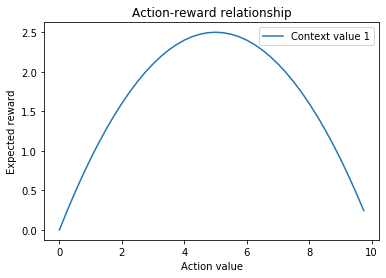

In [5]:
%matplotlib inline
# 10 arm values exist; the best one is the fifth one.
xa = np.arange(0, 10, 0.25)
ya1 = -(1/10)*xa**2 + 1*xa
plt.title('Action-reward relationship')
plt.plot(xa, ya1, label='Context value 1')
plt.xlabel("Action value"); plt.ylabel("Expected reward"); plt.legend()

*Note: not all action-reward functions are expected but a function with inverted u-shape structure is intuitivelly a good guess. This structure dictates that an intermediate value (if a good range is selected) should better. That's the result of parameter studies that consider different bandit algorihms and parameters in Figure 2.6 of [2].*

Summarizing:

  1- Each arm has an expected context-reward value for each context. When contexts values are defined in the continuous space, these context-reward values move smoothly across contexts, which are not independent anymore. Also, each action has an expected general-reward value, considering a fixed distribution of contexts. That would be the average reward value for each of the arms in the Context-reward relationship plot above, assuming a uniform distribution of contexts. If contexts are not available, a good bandit would point to the arm with highest average several times. That's actually the context-free bandits problem.
  
  2- Each context has an expected action-reward value for arm. When arm values are defined in the in the continuous space, these action-reward values move smoothly across actions, which are not independent anymore. Also, each context has an expected general-reward value, considering a fixed distribution of arms (actually, this distribution changes as we change our policy during the search). That would be the average reward value for each of the contexts in the Action-reward relationship plot above, assuming a uniform distribution of contexts. Knowing the expected general-reward for each context is not too important (for example, it does not matter to know which contexts return higher rewards or so) because the selection of contexts is not under our control; even though a distribution still exists.

Statement (1) made it possible the definition of a smoothly function for each independent arm in the context-reward plot. But it also has one important implication in the action-reward plot. It states that two similar contexts must have similar action-reward functions, as shown below, whose distance between contexts is 0.1.

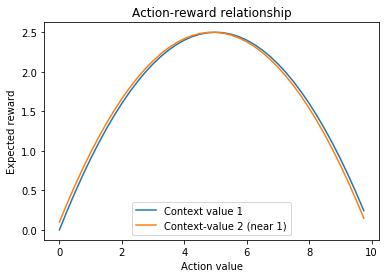

In [6]:
%matplotlib inline
# 10 arm values exist; the best one is the fifth one.
xa = np.arange(0, 10, 0.25)
ya1 = -(1/10)*xa**2 + 1*xa
ya2 = -(1./10)*(xa+.1)**2 + 1.*(xa+.1)
plt.title('Action-reward relationship')
plt.plot(xa, ya1, label='Context value 1'); plt.plot(xa, ya2, label='Context-value 2 (near 1)');
plt.xlabel("Action value"); plt.ylabel("Expected reward"); plt.legend()

Similarly, statement (1) made it possible the definition of a smoothly function for each independent context in the action-reward plot. But it also has one important implication in the context-reward plot. It states that two similar actions must have similar action-reward functions, as shown below, whose distance between cactions is also 0.1. It makes sense: we may expect a similar behavior of context-reward functions when similar arms are compared.

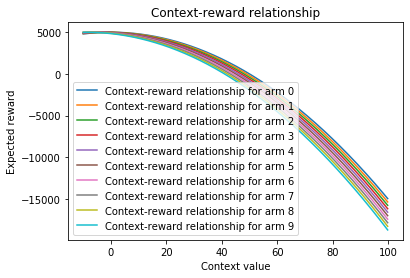

In [7]:
x = np.arange(-10, 100, 0.1)
plt.title('Context-reward relationship')
for i in range(10): 
    c2 = -2*(x+i)**2 + 5000
    plt.plot(x, c2, label = 'Context-reward relationship for arm {0}'.format(str(i)))
plt.ylabel('Expected reward')
plt.xlabel('Context value')
plt.legend()
plt.show()

Statement (1) made it possible the generalization between contexts and rewards used by LinUCB; what statement (2) can do for us?

It makes it possible for the algorithm to use arm values besides context values in the reward function as approached by the Hybrid approach presented in [1]. Actually, the Hybrid approach is more general and can include any function of the selected arm. Here, I state that by including the arm value *a* in the combined context vector (beta) when *a* is continuous (not the case of [1]) opens the possibility for the algorithm to learn the action-reward relationship besides the context-reward relationship. In the hybrid approach, a model for each action and thus a definition of a pool of values is still needed, but the knowledge about the action-reward relationship is shared between all arms.

Another approach could be possible but an extensive study would needed to confirm that. A simple description appears below.

There's an expected reward function for each context defined in R, because action values are defined in the metric space; and there's expected reward function for each arm in R because context values are also defined in the metric space.

Given two independent random variables, X and Y where:
  - X is the context at each trial t.
  - Y is the action at each trial t.
  - f(X) is the action-reward function for context X.
  - f(Y) is the context-reward function for action Y;

it's true that:

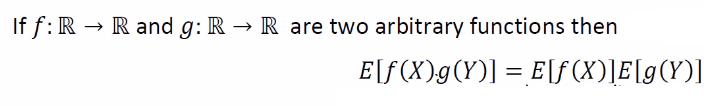

In [8]:
Image("img1.png")

The expected reward for each pair would be given by the multiplication of the expected values. Let's see an example that combines the action-reward and context-reward function we've seen so far.

Note that even though a single action is better, it does not mean it's better on all contexts.
That's actually a discretization of this general result on the 3d-plot that appears below.

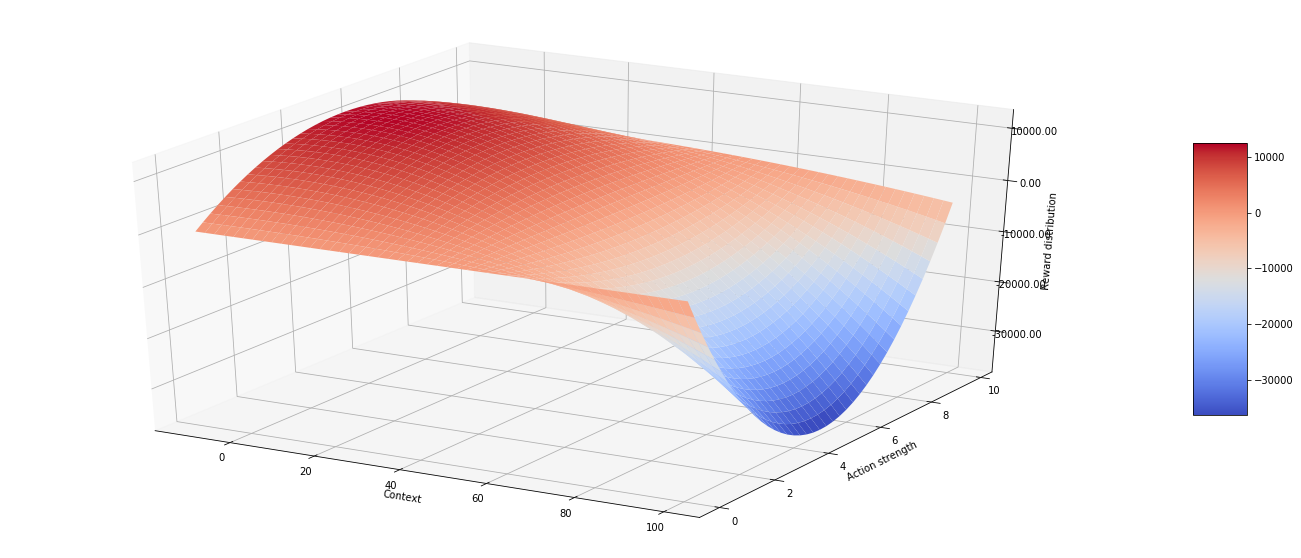

In [9]:
%matplotlib inline
#matplotlib qt

fig = plt.figure(figsize=(25,10))
ax = fig.gca(projection='3d')

X = np.arange(-10, 100, 0.1) # context space
Y = np.arange(0, 10, 0.25) # action space
X, Y = np.meshgrid(X, Y)
context = -2*X**2 + 5000
action_strength = -(1/10)*Y**2 + Y
Z = context*action_strength

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=True)

ax.set_xlabel('Context')
ax.set_ylabel('Action strength')
ax.set_zlabel('Reward distribution')
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

*Note: the bandit could learn this nonlinear relationship by applying non-linear transformations on existing features (both shared and disjoint): an hyperplane learned in a higher dimensional space would be a nonlinear surface on this 3-d original space.*

In the plot above action-reward values move smoothly across context values and context-reward values move smoothly across action values. Also, for each context value *c* there's at least one arm that it has a better at *c*.

What could we do? We could try to learn such function during trials (allowing nonlinear functions to be modeled) and as contexts appear to us, we've select the arm that would maximize the reward given the current estimate. An example is shown bellow.

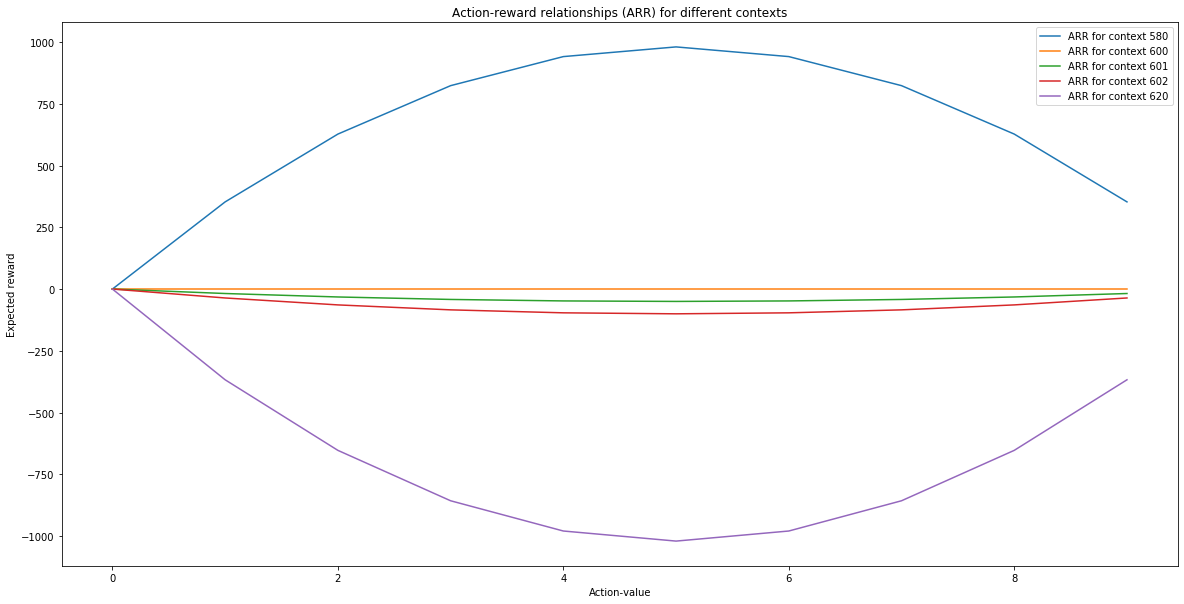

In [24]:
X = np.arange(-10, 100, 0.1) # context space
Y = np.arange(0, 10, 1) # action space
reward_action = -(1/10)*Y**2 + Y

plt.figure(figsize=(20,10))
plt.title('Action-reward relationships (ARR) for different contexts')

contexts = [580, 600, 601, 602, 620] # say that each of the contexts are presented
for ctx_sample in contexts:
    lbl = 'ARR for context {0}'.format(str(ctx_sample))
    plt.plot(Y, reward_action*(-2*X[ctx_sample]**2 + 5000), label=lbl)
plt.xlabel('Action-value'); plt.ylabel('Expected reward')
plt.legend()


Note that depending on the context values, the best action varies. However, this change is smoothly across context values.

This novel approach may have some issues, some of them are:
   - the development of a regret analysis would be necessary;
   - while it is not clear whether the distribution of contexts varies or not, the distribution of actions during the search does varies; this may affect the expectation statement above;
   - maybe, it's not possible to learn a reward function in terms of bound but only in terms of estimates, based on averages;
   - possibly, the above study considers an uniform distribution of contexts; how could we generalize this?;
   - ...

### 2. Testing the Hybrid LinUCB approach

Both the context and action defined in the real space change the behavior of the reward distribution (y). The action has an impact on the reward given by an inverted u-shape curve. That's intuitivelly expected: an intermediate value of action's strength that maximizes the reward given a context.

We'll test the HybridLinUCB approach in a case where the underlying reward function explicitly depends on action-values. The dependence on the context-values and action-values appear right below, even though such functions are unknown to the algorithm.

In [20]:
X = np.arange(-10, 100, 0.1) # context domain
Y = np.arange(0, 10, 1) # action domain
reward_context = -2*X**2 + 5000
reward_action = -(1/10)*Y**2 + Y

In [21]:
Y

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [28]:
def reward_context(context_value):
    return -2*context_value**2 + 5000
def reward_action(action_value):
    return -(1/10)*action_value**2 + action_value

#### 2.1 Building the client's algorithm

In [158]:
def testing_hybridLinUCB(X, Y, ctx_strategy, alpha, noise=0, T=1000):
    # noise: std deviation of a normal distribution whose mean is the correct reward
    
    # initializing the bandit
    poly = {"Degree": 2, # degree of nonlinearity
           "Loose interaction":False} # all terms of higher-order terms are modeled if False
    lucb.initializeLinUcbHybrid(alpha=alpha, d=1, k=1, d_polynomial=poly, k_polynomial=poly)
    
    # creating the arms
    arms = []
    for a_val in Y:
        a = lucb.LinUcbHybrid(a_val)
        arms.append(a)
    
    seq_contexts = []; seq_rewards = []; seq_actions = []
    for t in range(T):
        if t % 100 == 0:
            print('Iteration',  t)
        
        # case 1: context is fixed
        if ctx_strategy == 1:
            idx = 580 # 5 is the best arm
        # case 2: contexts are changes between two extreme cases
        elif ctx_strategy == 2:
            idx = random.choice([580, 620]) # arms 0 and 9 are equally better in 620
        # case 3: general case: contexts are sampled from 'discretization' uniformly at random
        elif ctx_strategy == 3:
            idx = random.choice(list(range(len(X))))
        context_value = X[idx]
        
        arms[0].evaluate_beta() # it's better to create a class method
        for i, a in enumerate(arms):
            #print('Arm', i)
            a.update_contexts(np.array([[context_value]]), np.array([[a.value]]))
            a.evaluate_theta()
            #print('Theta', a.theta)
            a.evaluate_ucb()
            #print('Variance', a.variance[0][0])
            #print('Estimate', a.estimate[0][0])
        ucb_values = np.array([a.ucb for a in arms])
        #print(ucb_values)
        aidx = np.random.choice(np.flatnonzero(ucb_values == ucb_values.max())) # ties broken randomly
        
        # generating deterministically the reward
        correct_reward = reward_context(context_value)*reward_action(arms[aidx].value)
        reward = np.random.normal(correct_reward, noise)
        
        arms[aidx].update_A0(update=1)
        arms[aidx].update_b0(update=1)
        arms[aidx].update_A()
        arms[aidx].update_B()
        arms[aidx].update_b(reward)
        arms[aidx].update_A0(update=2)
        arms[aidx].update_b0(update=2, r=reward)
        
        seq_contexts.append(idx)
        seq_rewards.append(reward)
        seq_actions.append(arms[aidx].value)
        
    return seq_rewards, seq_contexts, seq_actions

#### 2.2 Testing the algorithm in a single context

In [99]:
rws, ctxs, acts = testing_hybridLinUCB(X, Y, alpha=0.5, ctx_strategy=1, noise=0, T=100)

Iteration 0


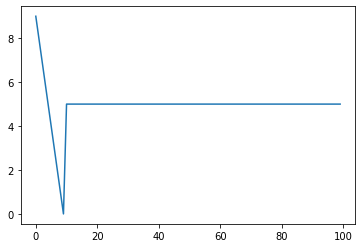

In [100]:
plt.plot(acts)

Note that with noise 0, the algorithm could converge to the optimal arm in aproximately 10 iterations.
Let's increase the noise a bit.

Iteration 0


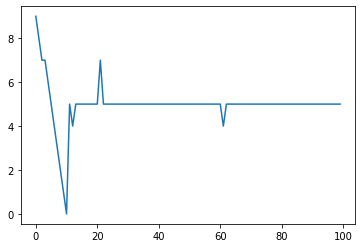

In [102]:
rws, ctxs, acts = testing_hybridLinUCB(X, Y, alpha=0.5, ctx_strategy=1, noise=200, T=100)
plt.plot(acts)

Converge still occur.

Let's now see the behavior of this algorithm across several values of noise and alpha.

In [139]:
alphas = [0, 0.1, 0.25, 0.5, 0.75, 1, 2, 5, 10, 20]
noises = [0, 1, 10, 100, 250, 500, 1000]
data = []
for i, alpha in enumerate(alphas):
    d = {}
    d['Alpha'] = alpha
    for j, noise in enumerate(noises):
        rws, _, _ = testing_hybridLinUCB(X, Y, alpha=alpha, ctx_strategy=1, noise=noise, T=500)
        d['Noise {0}'.format(str(noise))] = np.mean(rws)
    data.append(d)

Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 0
Iteration 100
Iteration 200
Iteratio

(0, 10)

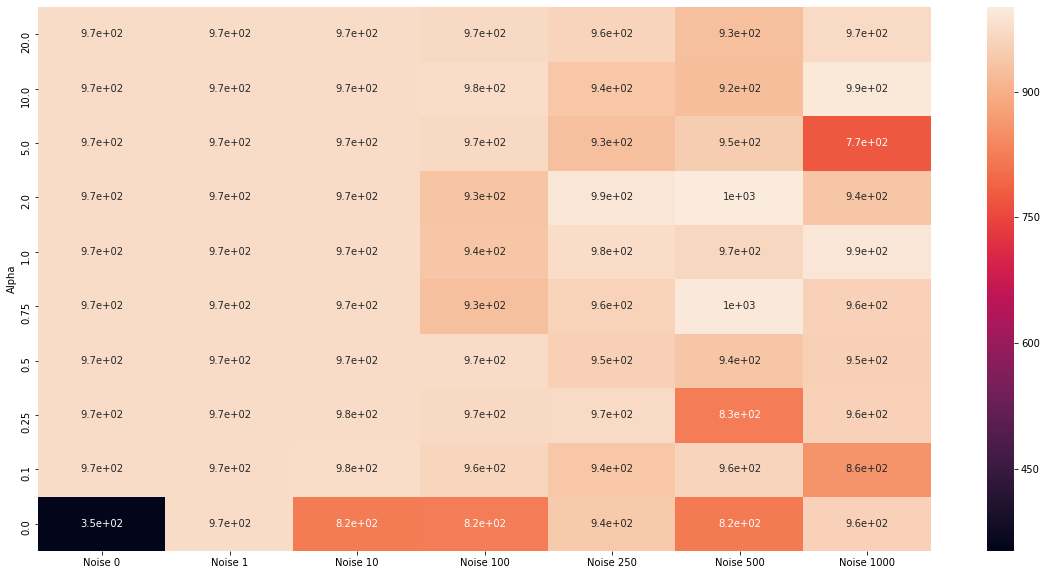

In [148]:
df = pd.DataFrame(data)
df.set_index('Alpha', inplace=True)
plt.figure(figsize=(20,10))
sns.heatmap(df, annot=True)
#plt.ylim([0, 10])

Note that 0.5 is a reasonable value for alpha in this problem.

Strangely, when alpha both alpha and noise are zero, the performance appear to be very poor. Let's run again the algorithm for this case.

Iteration 0


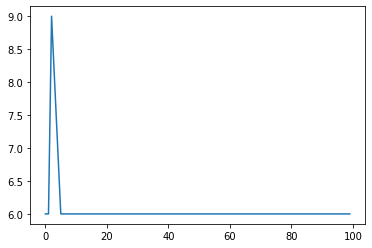

In [151]:
rws, ctxs, acts = testing_hybridLinUCB(X, Y, alpha=0, ctx_strategy=1, noise=0, T=100)
plt.plot(acts)

The behavior of the algorithm depends on the actions taken at the beggining. Because the output is deterministic, the algorithm stick with the best arm tried so far, considering only the estimate (isn't should it stick with the first arm with positive reward?). Note how the noise can be beneficial in this case.

#### 2.3 Testing the algorithm in two very different contexts

In [199]:
rws, ctxs, acts = testing_hybridLinUCB(X, Y, alpha=0.1, ctx_strategy=2, noise=100, T=1000)

Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Iteration 600
Iteration 700
Iteration 800
Iteration 900


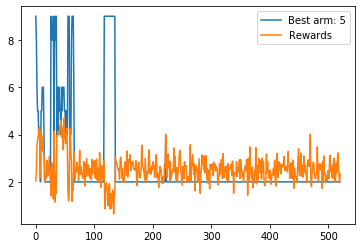

In [200]:
acts_580 = np.array(acts)[np.where(np.array(ctxs)==580)]
rws_580 = np.array(rws)[np.where(np.array(ctxs)==580)]
#acts_620 = np.array(acts)[np.where(np.array(ctxs)==620)]
plt.plot(acts_580, label='Best arm: 5')
plt.plot(rws_580/250, label='Rewards')
#plt.plot(acts_620, label='Best arm: 0, 9')
plt.legend()

In [166]:
t = [1,2,3,4]
t = np.array(t)
t[np.array([0,2])]

array([1, 3])

### References
[1] LI, Lihong et al. A contextual-bandit approach to personalized news article recommendation. In: **Proceedings of the 19th international conference on World wide web**. 2010. p. 661-670.

[2] SUTTON, Richard S.; BARTO, Andrew G. **Reinforcement learning: An introduction**. MIT press, 2018.

[3] SLIVKINS, Aleksandrs et al. Introduction to multi-armed bandits. **Foundations and Trends® in Machine Learning**, v. 12, n. 1-2, p. 1-286, 2019.

[4] LUDERS, Multi-Armed Bandit (MAB) - LinUCB - Nota 1.